# Imports

Importing necessary modules and libraries, fetching and splitting the dataset, defining classes.

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 27.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 56.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 15.5 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import re
from tqdm.auto import tqdm
from statistics import mean
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pylab import rcParams
from matplotlib.ticker import MaxNLocator
from matplotlib import rc


sns.set(style='whitegrid', palette='muted', font_scale=1.2)
rcParams['figure.figsize'] = 12, 8

In [ ]:
from matplotlib.pyplot import figure

In [ ]:
from transformers import BertTokenizer
import torch
from torch import nn
from transformers import BertModel
from torch.optim import Adam
from tqdm import tqdm

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!tar -xvf "/content/drive/MyDrive/sep.tar" -C "sep_models"     #[run this cell to extract tar files]

bocks.pt
brown_ales.pt
dark_ales.pt
dark_lagers.pt
ipa.pt
pale_ales.pt
pale_lagers.pt
porters.pt
specialty.pt
stouts.pt
strong_ales.pt
wheat_beers.pt
wild-sour_beers.pt


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/beer_df_large.csv", sep="\t")

In [ ]:
df.sample(5)

,Name,Company,Group,Region,Style,ABV,Avg,Review,Rate
81656,Faust Festbier,Brauhaus Faust-Miltenberger,Pale Lagers,Germany,Festbier / Wiesnbier,5.5%,4.04,"A rather odd scoring, but let me explain.\n\nI...",3.84
82508,Simpler Times Pilsner,Minhas Craft Brewery,Pale Lagers,"Wisconsin, United States",German Pilsner,5.5%,3.04,So for starters this is a $3.99 for a six pack...,3.30
35514,Pineapple Brut IPA,Sockeye Grill & Brewery,India Pale Ales,"Idaho, United States",Brut IPA,7%,3.84,This is a nice IPA. Had at Sockeye Brewery in ...,4.17
120401,Broken Heart Stout,Broken Bow Brewery,Stouts,"New York, United States",American Stout,6.4%,3.44,Didn't expect much from this one but was defin...,3.74
57565,Primator English Pale Ale,Pivovar Náchod a.s.,Pale Ales,Czechia,English Pale Ale,5%,3.45,Served cold from 500ml bottle into pilsner mug...,3.90


In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

In [ ]:
df['Flat'] = df.apply(lambda x: '{}. {}'.format(x['Group'], x['Style']), axis=1)

In [ ]:
df_train, df_test = train_test_split(df, train_size=0.9, random_state=42, stratify=df['Flat'])
df_train, df_val = train_test_split(df_train, train_size=0.88889, random_state=42, stratify=df_train['Flat'])
print(len(df_train), len(df_test), len(df_val))

139746 17469 17469


In [ ]:
def plot_confusion_matrix(y_true, y_pred, labels):
    # Get confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Define class labels
    classes = sorted(list(set(y_true)))
    
    # Create heatmap
    sns.heatmap(cm, annot=False, cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.show()

Labels on cells are removed because the matrix is too large.

# Hierarchical-Separate approach

In [ ]:
labels2id = {}
for i, name in enumerate(df['Group'].value_counts().index.tolist()):
    labels2id[name] = i

In [ ]:
labels2id

{'Pale Lagers': 0,
 'Pale Ales': 1,
 'Strong Ales': 2,
 'Stouts': 3,
 'India Pale Ales': 4,
 'Wild/Sour Beers': 5,
 'Specialty Beers': 6,
 'Dark Lagers': 7,
 'Porters': 8,
 'Wheat Beers': 9,
 'Brown Ales': 10,
 'Bocks': 11,
 'Dark Ales': 12}

In [ ]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, df):
        self.labels = [labels2id[label] for label in df['Group']]
        self.texts = [tokenizer(text, 
                                padding='max_length', 
                                max_length = 512, 
                                truncation=True,
                                return_tensors="pt") for text in df['Review']]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

In [ ]:
class BertClassifier(nn.Module):
    def forward(self, input_id, mask):
        _, pooled_output = self.bert(input_ids=input_id, attention_mask=mask,return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.relu(linear_output)
        return final_layer

In [ ]:
model_path = '/content/drive/MyDrive/group.pt'
model = torch.load(model_path)
model.eval()

BertClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tru

In [ ]:
def evaluate(model, test_data):
    y_preds = []
    y_trues = []
    test = Dataset(test_data)

    test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:

        model = model.cuda()

    total_acc_test = 0
    with torch.no_grad():

        for test_input, test_label in test_dataloader:

              test_label = test_label.to(device)
              mask = test_input['attention_mask'].to(device)
              input_id = test_input['input_ids'].squeeze(1).to(device)

              output = model(input_id, mask)

              acc = (output.argmax(dim=1) == test_label).sum().item()
              y_preds.append(output.argmax(dim=1))
              y_trues.append(test_label)
              total_acc_test += acc
    
    print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')
    return y_preds, y_trues

In [ ]:
y_preds, y_trues = evaluate(model, df_test)

Test Accuracy:  0.768


In [ ]:
y_preds_ = torch.cat(y_preds).cpu().numpy()
y_trues_ = torch.cat(y_trues).cpu().numpy()

In [ ]:
preds_labels = []
for i in y_preds_:
  for k,v in labels2id.items():
    if v == i:
      preds_labels.append(k)

In [ ]:
trues_labels = []
for i in y_trues_:
  for k,v in labels2id.items():
    if v == i:
      trues_labels.append(k)

##### Second model

In [ ]:
class BertClassifier(nn.Module):
    def forward(self, input_id, mask):
        _, pooled_output = self.bert(input_ids=input_id, 
                                     attention_mask=mask, 
                                     return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.relu(linear_output)

        return final_layer

In [ ]:
df_test['Pred_group'] = preds_labels
df_test = df_test.drop(columns=['Name', 'Company', 'Region', 'ABV', 'Avg', 'Rate'])

In [ ]:
df_test

,Group,Style,Review,Flat,Pred_group
81152,Pale Lagers,Festbier / Wiesnbier,16oz can into a 16oz dimple mug.\nL: Pours lig...,Pale Lagers. Festbier / Wiesnbier,Pale Lagers
144794,Strong Ales,Imperial Red Ale,A: The beer is somewhat hazy dark reddish ambe...,Strong Ales. Imperial Red Ale,Strong Ales
142897,Strong Ales,English Barleywine,A - Poured a brown color with an off white hea...,Strong Ales. English Barleywine,Strong Ales
171418,Wild/Sour Beers,Gose,Yep pretty to look at a super jammy. I wonder ...,Wild/Sour Beers. Gose,Wild/Sour Beers
13215,Dark Ales,Dubbel,Very solid Belgian Dubbel. Ice tea appearance ...,Dark Ales. Dubbel,Dark Ales
...,...,...,...,...,...
134179,Strong Ales,American Barleywine,"Pours a dark, muddy brown with 1 finger of lig...",Strong Ales. American Barleywine,Strong Ales
64684,Pale Ales,Saison,L: Bright gold with a touch of haze (before yo...,Pale Ales. Saison,Pale Ales
130685,Stouts,Sweet / Milk Stout,"I tried this at the Roanoke, VA location. It p...",Stouts. Sweet / Milk Stout,Stouts
123586,Stouts,Irish Dry Stout,Pours black with a soda-like fizzy head. Aroma...,Stouts. Irish Dry Stout,Stouts


In [ ]:
labels2 = {'Pale Lagers': {0: 'American Adjunct Lager', 1: 'German Pilsner', 2: 'European Pale Lager', 3: 'American Lager', 4: 'Helles', 5: 'Bohemian / Czech Pilsner', 6: 'Light Lager', 7: 'Kellerbier / Zwickelbier', 8: 'European / Dortmunder Export Lager', 9: 'Festbier / Wiesnbier', 10: 'European Strong Lager', 11: 'Malt Liquor', 12: 'India Pale Lager (IPL)', 13: 'Imperial Pilsner', 14: 'Czech Pale Lager'}, 'Pale Ales': {0: 'English Pale Ale', 1: 'American Blonde Ale', 2: 'Saison', 3: 'American Pale Ale', 4: 'Kölsch', 5: 'American Amber / Red Ale', 6: 'Belgian Pale Ale', 7: 'English Bitter', 8: 'Extra Special / Strong Bitter (ESB)', 9: 'Irish Red Ale', 10: 'Belgian Blonde Ale', 11: 'Bière de Garde', 12: 'Grisette', 13: 'English Pale Mild Ale'}, 'Strong Ales': {0: 'Tripel', 1: 'Belgian Pale Strong Ale', 2: 'Belgian Dark Strong Ale', 3: 'English Barleywine', 4: 'American Barleywine', 5: 'Scotch Ale / Wee Heavy', 6: 'Quadrupel (Quad)', 7: 'American Strong Ale', 8: 'Old Ale', 9: 'Imperial Red Ale', 10: 'English Strong Ale', 11: 'Wheatwine'}, 'Stouts': {0: 'Russian Imperial Stout', 1: 'American Imperial Stout', 2: 'Sweet / Milk Stout', 3: 'American Stout', 4: 'Oatmeal Stout', 5: 'Irish Dry Stout', 6: 'Foreign / Export Stout', 7: 'English Stout'}, 'India Pale Ales': {0: 'Imperial IPA', 1: 'American IPA', 2: 'New England IPA', 3: 'English IPA', 4: 'Black IPA', 5: 'Milkshake IPA', 6: 'Belgian IPA', 7: 'Brut IPA'}, 'Wild/Sour Beers': {0: 'Wild Ale', 1: 'Gose', 2: 'Fruited Kettle Sour', 3: 'Berliner Weisse', 4: 'Fruit Lambic', 5: 'Flanders Red Ale', 6: 'Flanders Oud Bruin', 7: 'Brett Beer', 8: 'Gueuze', 9: 'Lambic', 10: 'Faro'}, 'Specialty Beers': {0: 'Fruit and Field Beer', 1: 'Pumpkin Beer', 2: 'Low-Alcohol Beer', 3: 'Herb and Spice Beer', 4: 'Rye Beer', 5: 'Smoked Beer', 6: 'Chile Beer', 7: 'Japanese Rice Lager', 8: 'Gruit / Ancient Herbed Ale', 9: 'Kvass', 10: 'Happoshu', 11: 'Sahti'}, 'Dark Lagers': {0: 'Märzen', 1: 'Munich Dunkel', 2: 'Schwarzbier', 3: 'Vienna Lager', 4: 'American Amber / Red Lager', 5: 'European Dark Lager', 6: 'Czech Dark Lager', 7: 'Rauchbier', 8: 'Czech Amber Lager'}, 'Porters': {0: 'American Porter', 1: 'Imperial Porter', 2: 'Baltic Porter', 3: 'English Porter', 4: 'Robust Porter', 5: 'Smoked Porter'}, 'Wheat Beers': {0: 'Hefeweizen', 1: 'Witbier', 2: 'American Pale Wheat Beer', 3: 'Dunkelweizen', 4: 'Kristallweizen', 5: 'Grodziskie', 6: 'American Dark Wheat Beer'}, 'Brown Ales': {0: 'American Brown Ale', 1: 'English Brown Ale', 2: 'Altbier', 3: 'English Dark Mild Ale', 4: 'Belgian Dark Ale'}, 'Bocks': {0: 'Doppelbock', 1: 'Bock', 2: 'Maibock', 3: 'Weizenbock', 4: 'Eisbock'}, 'Dark Ales': {0: 'Winter Warmer', 1: 'Dubbel', 2: 'Scottish Ale', 3: 'Roggenbier'}}

In [ ]:
labels3 = {}
for k, v in labels2.items():
    labels3[k] = {v:k for k, v in v.items()}
    labels3[k]['no data'] = 100

In [ ]:
labels3

{'Pale Lagers': {'American Adjunct Lager': 0,
  'German Pilsner': 1,
  'European Pale Lager': 2,
  'American Lager': 3,
  'Helles': 4,
  'Bohemian / Czech Pilsner': 5,
  'Light Lager': 6,
  'Kellerbier / Zwickelbier': 7,
  'European / Dortmunder Export Lager': 8,
  'Festbier / Wiesnbier': 9,
  'European Strong Lager': 10,
  'Malt Liquor': 11,
  'India Pale Lager (IPL)': 12,
  'Imperial Pilsner': 13,
  'Czech Pale Lager': 14,
  'no data': 100},
 'Pale Ales': {'English Pale Ale': 0,
  'American Blonde Ale': 1,
  'Saison': 2,
  'American Pale Ale': 3,
  'Kölsch': 4,
  'American Amber / Red Ale': 5,
  'Belgian Pale Ale': 6,
  'English Bitter': 7,
  'Extra Special / Strong Bitter (ESB)': 8,
  'Irish Red Ale': 9,
  'Belgian Blonde Ale': 10,
  'Bière de Garde': 11,
  'Grisette': 12,
  'English Pale Mild Ale': 13,
  'no data': 100},
 'Strong Ales': {'Tripel': 0,
  'Belgian Pale Strong Ale': 1,
  'Belgian Dark Strong Ale': 2,
  'English Barleywine': 3,
  'American Barleywine': 4,
  'Scotch Ale 

In [ ]:
class Dataset2(torch.utils.data.Dataset):
    def __init__(self, df, labels):
        self.labels = [labels[label] if label in labels else 100 for label in df['Style']]
        self.texts = [tokenizer(text, 
                                padding='max_length',
                                max_length = 512, 
                                truncation=True,
                                return_tensors="pt") 
                        for text in df['Review']]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

In [ ]:
def evaluate2(model, test_data, ld):
    y_preds = []
    y_trues = []
    test = Dataset2(test_data, ld)

    test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:
        model = model.cuda()

    total_acc_test = 0
    with torch.no_grad():

        for test_input, test_label in tqdm(test_dataloader):
              
              test_label = test_label.to(device)
              mask = test_input['attention_mask'].to(device)
              input_id = test_input['input_ids'].squeeze(1).to(device)

              output = model(input_id, mask)

              acc = (output.argmax(dim=1) == test_label).sum().item()

              y_preds.append(output.argmax(dim=1))
              y_trues.append(test_label)
              
              total_acc_test += acc
    
    print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')
    return y_preds, y_trues, total_acc_test / len(test_data)

In [ ]:
models_paths = {'Pale Lagers': 'sep_models/pale_lagers.pt',
 'Pale Ales': 'sep_models/pale_ales.pt',
 'Strong Ales': 'sep_models/strong_ales.pt',
 'Stouts': 'sep_models/stouts.pt',
 'India Pale Ales': 'sep_models/ipa.pt',
 'Wild/Sour Beers': 'sep_models/wild-sour_beers.pt',
 'Specialty Beers': 'sep_models/specialty.pt',
 'Dark Lagers': 'sep_models/dark_lagers.pt',
 'Porters': 'sep_models/porters.pt',
 'Wheat Beers': 'sep_models/wheat_beers.pt',
 'Brown Ales': 'sep_models/brown_ales.pt',
 'Bocks': 'sep_models/bocks.pt',
 'Dark Ales': 'sep_models/dark_ales.pt'}

In [ ]:
from tqdm.auto import tqdm

In [ ]:
res = {}

for group in df_test.Pred_group.unique():
    
    print('==== EVALUATING {} ===='.format(group))
    df2eval = df_test[df_test.Pred_group == group]

    label_dict = labels3[group]

    model_name = models_paths[group]
    print('MODEL LOADED: {}'.format(model_name))

    model = torch.load(model_name)
    model.eval()

    yp, yt, acc = evaluate2(model, df2eval, label_dict)
    res[group] = (yp, yt, acc)

==== EVALUATING Pale Lagers ====
MODEL LOADED: pale_lagers.pt


  0%|          | 0/1469 [00:00<?, ?it/s]

Test Accuracy:  0.528
==== EVALUATING Strong Ales ====
MODEL LOADED: strong_ales.pt


  0%|          | 0/1127 [00:00<?, ?it/s]

Test Accuracy:  0.516
==== EVALUATING Wild/Sour Beers ====
MODEL LOADED: wild-sour_beers.pt


  0%|          | 0/655 [00:00<?, ?it/s]

Test Accuracy:  0.682
==== EVALUATING Dark Ales ====
MODEL LOADED: dark_ales.pt


  0%|          | 0/121 [00:00<?, ?it/s]

Test Accuracy:  0.730
==== EVALUATING Bocks ====
MODEL LOADED: bocks.pt


  0%|          | 0/141 [00:00<?, ?it/s]

Test Accuracy:  0.733
==== EVALUATING Dark Lagers ====
MODEL LOADED: dark_lagers.pt


  0%|          | 0/614 [00:00<?, ?it/s]

Test Accuracy:  0.488
==== EVALUATING Specialty Beers ====
MODEL LOADED: specialty.pt


  0%|          | 0/581 [00:00<?, ?it/s]

Test Accuracy:  0.713
==== EVALUATING Pale Ales ====
MODEL LOADED: pale_ales.pt


  0%|          | 0/1335 [00:00<?, ?it/s]

Test Accuracy:  0.485
==== EVALUATING Brown Ales ====
MODEL LOADED: brown_ales.pt


  0%|          | 0/284 [00:00<?, ?it/s]

Test Accuracy:  0.575
==== EVALUATING Porters ====
MODEL LOADED: porters.pt


  0%|          | 0/321 [00:00<?, ?it/s]

Test Accuracy:  0.596
==== EVALUATING Stouts ====
MODEL LOADED: stouts.pt


  0%|          | 0/1004 [00:00<?, ?it/s]

Test Accuracy:  0.476
==== EVALUATING India Pale Ales ====
MODEL LOADED: ipa.pt


  0%|          | 0/712 [00:00<?, ?it/s]

Test Accuracy:  0.695
==== EVALUATING Wheat Beers ====
MODEL LOADED: wheat_beers.pt


  0%|          | 0/375 [00:00<?, ?it/s]

Test Accuracy:  0.734


In [ ]:
from statistics import mean
round(mean([i[2] for i in [res[k] for k in res]]), 2)

0.61

==== CLASSIFICATION REPORT FOR Pale Lagers ====
              precision    recall  f1-score   support

           0       0.46      0.82      0.59       287
           1       0.51      0.74      0.61       271
           2       0.56      0.70      0.62       254
           3       0.40      0.68      0.51       238
           4       0.56      0.70      0.62       255
           5       0.57      0.50      0.53       252
           6       0.65      0.62      0.63       190
           7       0.48      0.76      0.59       147
           8       0.73      0.18      0.29       104
           9       0.64      0.61      0.62        79
          10       0.60      0.77      0.67        94
          11       0.70      0.72      0.71        87
          12       0.75      0.62      0.68        65
          13       0.67      0.06      0.12        31
          14       0.00      0.00      0.00        31
         100       0.00      0.00      0.00       552

    accuracy                    

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


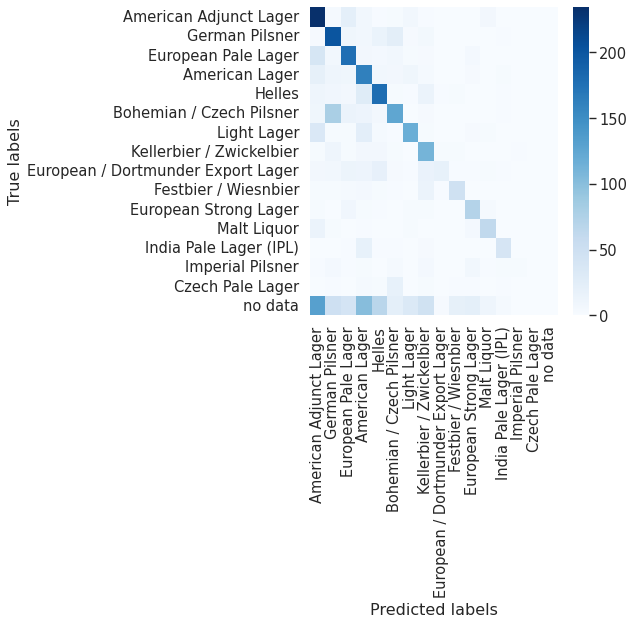

==== CLASSIFICATION REPORT FOR Strong Ales ====
              precision    recall  f1-score   support

           0       0.71      0.69      0.70       218
           1       0.43      0.79      0.56       168
           2       0.44      0.80      0.57       200
           3       0.44      0.75      0.55       202
           4       0.55      0.60      0.58       195
           5       0.56      0.87      0.68       161
           6       0.68      0.76      0.72       182
           7       0.47      0.65      0.55       131
           8       0.53      0.38      0.44        73
           9       0.46      0.56      0.50        48
          10       0.38      0.43      0.40        51
          11       0.93      0.33      0.48        40
         100       0.00      0.00      0.00       585

    accuracy                           0.52      2254
   macro avg       0.51      0.58      0.52      2254
weighted avg       0.40      0.52      0.44      2254



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


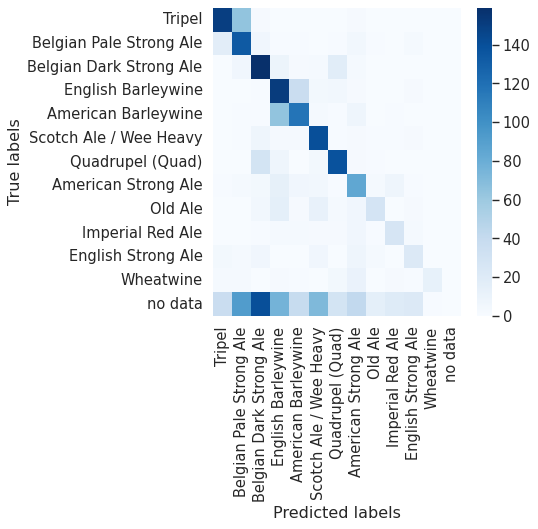

==== CLASSIFICATION REPORT FOR Wild/Sour Beers ====
              precision    recall  f1-score   support

           0       0.55      0.81      0.65       192
           1       0.86      0.85      0.86       192
           2       0.69      0.91      0.79       181
           3       0.80      0.75      0.78       171
           4       0.70      0.88      0.78       162
           5       0.61      0.53      0.57        78
           6       0.70      0.54      0.61        71
           7       0.44      0.71      0.55        42
           8       0.62      0.57      0.59        53
           9       0.00      0.00      0.00        22
          10       0.00      0.00      0.00         7
         100       0.00      0.00      0.00       139

    accuracy                           0.68      1310
   macro avg       0.50      0.54      0.51      1310
weighted avg       0.61      0.68      0.64      1310



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


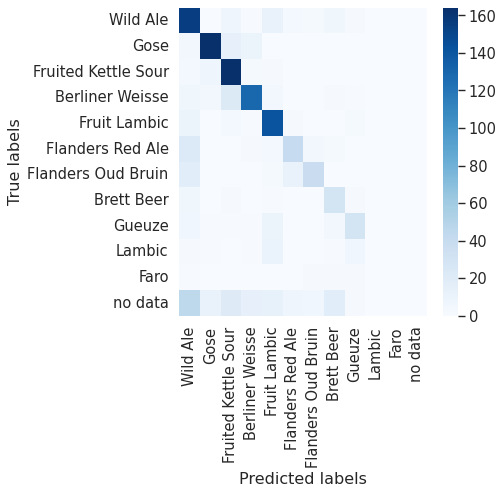

==== CLASSIFICATION REPORT FOR Dark Ales ====
              precision    recall  f1-score   support

           0       0.69      1.00      0.82       100
           1       0.87      0.96      0.91        55
           2       0.70      0.95      0.81        22
           3       0.40      0.67      0.50         3
         100       0.00      0.00      0.00        61

    accuracy                           0.73       241
   macro avg       0.53      0.72      0.61       241
weighted avg       0.55      0.73      0.63       241



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


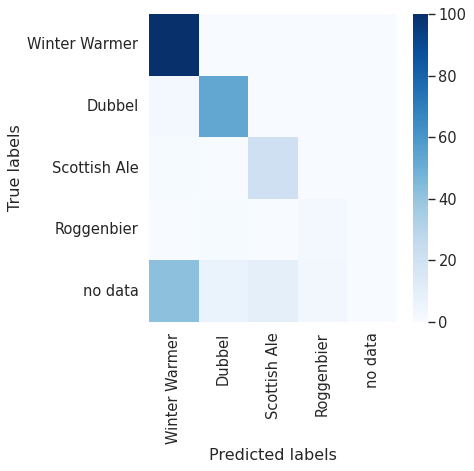

==== CLASSIFICATION REPORT FOR Bocks ====
              precision    recall  f1-score   support

           0       0.68      0.84      0.75        90
           1       0.64      0.76      0.70        62
           2       0.89      0.76      0.82        76
           3       0.81      0.86      0.83        29
           4       0.00      0.00      0.00         5
         100       0.00      0.00      0.00        19

    accuracy                           0.73       281
   macro avg       0.50      0.54      0.52       281
weighted avg       0.68      0.73      0.70       281



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


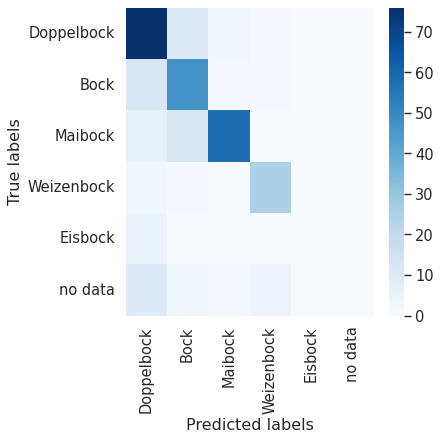

==== CLASSIFICATION REPORT FOR Dark Lagers ====
              precision    recall  f1-score   support

           0       0.68      0.96      0.80       225
           1       0.42      0.67      0.52       133
           2       0.37      0.94      0.53       115
           3       0.51      0.75      0.61       108
           4       0.29      0.47      0.36        68
           5       0.36      0.07      0.11        74
           6       0.55      0.24      0.34        66
           7       0.57      0.95      0.71        55
           8       0.00      0.00      0.00        15
         100       0.00      0.00      0.00       368

    accuracy                           0.49      1227
   macro avg       0.37      0.50      0.40      1227
weighted avg       0.34      0.49      0.38      1227



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


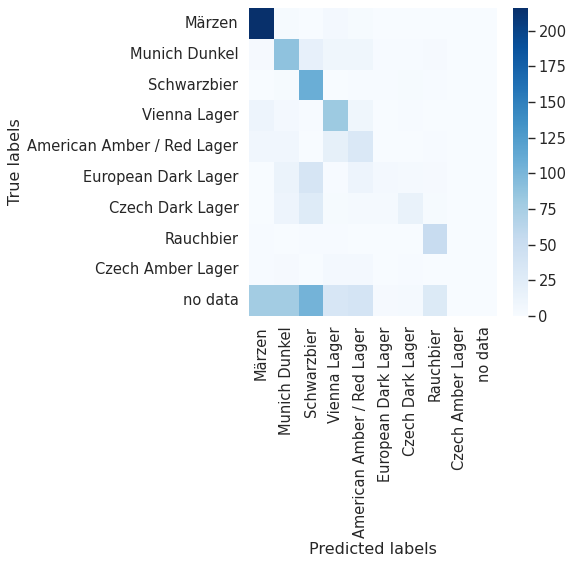

==== CLASSIFICATION REPORT FOR Specialty Beers ====
              precision    recall  f1-score   support

           0       0.61      0.97      0.75       164
           1       0.91      0.96      0.94       226
           2       0.86      0.95      0.90       125
           3       0.56      0.93      0.70        99
           4       0.63      0.95      0.76        83
           5       0.46      0.97      0.63        38
           6       0.76      0.97      0.85        58
           7       0.76      0.94      0.84        36
           8       1.00      0.18      0.30        17
           9       1.00      0.58      0.74        24
          10       1.00      0.86      0.92        14
          11       1.00      0.45      0.62        11
         100       0.00      0.00      0.00       266

    accuracy                           0.71      1161
   macro avg       0.73      0.75      0.69      1161
weighted avg       0.58      0.71      0.62      1161



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


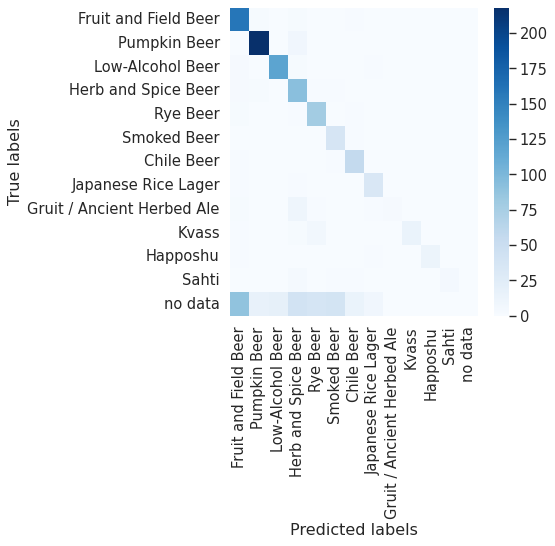

==== CLASSIFICATION REPORT FOR Pale Ales ====
              precision    recall  f1-score   support

           0       0.47      0.69      0.56       228
           1       0.43      0.79      0.56       165
           2       0.52      0.89      0.65       159
           3       0.53      0.86      0.65       175
           4       0.71      0.77      0.74       168
           5       0.40      0.80      0.53       160
           6       0.44      0.73      0.55       143
           7       0.47      0.64      0.54       155
           8       0.43      0.59      0.50       124
           9       0.47      0.82      0.60       104
          10       0.46      0.57      0.51        74
          11       0.63      0.66      0.64        67
          12       0.90      0.28      0.43        32
          13       0.00      0.00      0.00        21
         100       0.00      0.00      0.00       895

    accuracy                           0.48      2670
   macro avg       0.46      0.61 

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


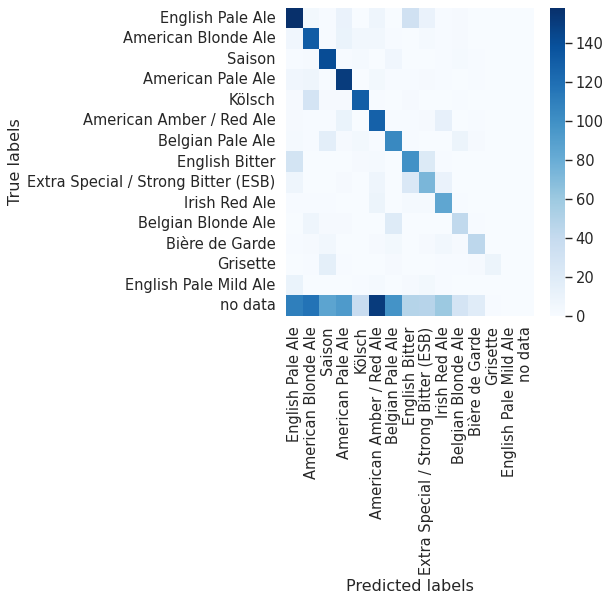

==== CLASSIFICATION REPORT FOR Brown Ales ====
              precision    recall  f1-score   support

           0       0.61      0.82      0.70       158
           1       0.52      0.76      0.61       125
           2       0.77      0.97      0.86        68
           3       0.43      0.72      0.54        50
           4       0.00      0.00      0.00        16
         100       0.00      0.00      0.00       150

    accuracy                           0.57       567
   macro avg       0.39      0.54      0.45       567
weighted avg       0.41      0.57      0.48       567



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


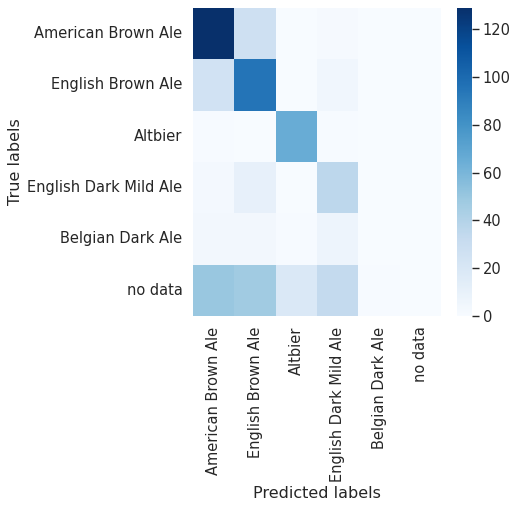

==== CLASSIFICATION REPORT FOR Porters ====
              precision    recall  f1-score   support

           0       0.46      0.92      0.61       161
           1       0.72      0.82      0.76        99
           2       0.87      0.75      0.80        96
           3       0.67      0.65      0.66       112
           4       0.25      0.02      0.03        59
           5       0.78      0.30      0.44        23
         100       0.00      0.00      0.00        91

    accuracy                           0.60       641
   macro avg       0.53      0.49      0.47       641
weighted avg       0.52      0.60      0.53       641



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


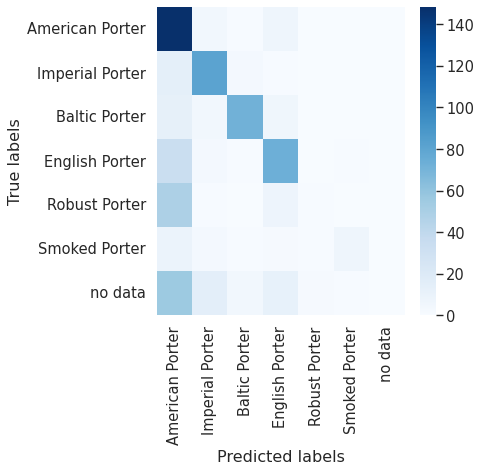

==== CLASSIFICATION REPORT FOR Stouts ====
              precision    recall  f1-score   support

           0       0.53      0.75      0.62       246
           1       0.51      0.67      0.58       242
           2       0.56      0.69      0.62       236
           3       0.38      0.67      0.49       212
           4       0.54      0.58      0.56       233
           5       0.45      0.78      0.57       122
           6       0.32      0.52      0.40        90
           7       0.36      0.35      0.36        83
         100       0.00      0.00      0.00       544

    accuracy                           0.48      2008
   macro avg       0.41      0.56      0.47      2008
weighted avg       0.35      0.48      0.40      2008



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


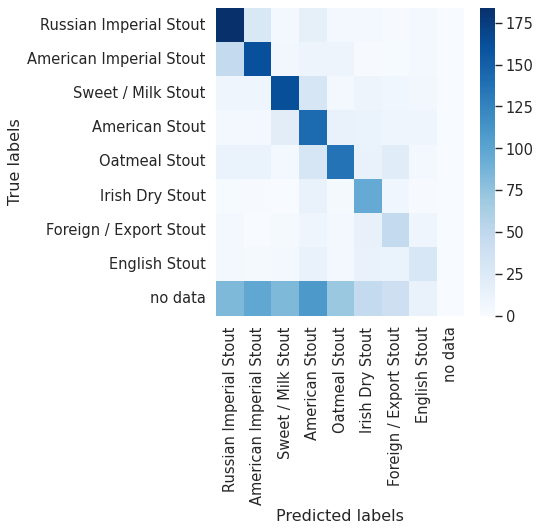

==== CLASSIFICATION REPORT FOR India Pale Ales ====
              precision    recall  f1-score   support

           0       0.67      0.82      0.73       229
           1       0.57      0.86      0.68       222
           2       0.71      0.90      0.79       212
           3       0.71      0.74      0.72       125
           4       0.80      0.95      0.87       131
           5       0.84      0.91      0.87       128
           6       0.71      0.78      0.74        69
           7       0.97      0.71      0.82        45
         100       0.00      0.00      0.00       262

    accuracy                           0.70      1423
   macro avg       0.66      0.74      0.69      1423
weighted avg       0.58      0.70      0.63      1423



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


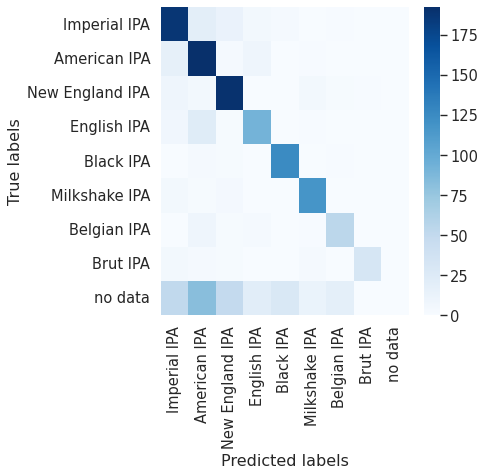

==== CLASSIFICATION REPORT FOR Wheat Beers ====
              precision    recall  f1-score   support

           0       0.75      0.89      0.82       217
           1       0.81      0.97      0.88       173
           2       0.67      0.90      0.77       141
           3       0.61      0.86      0.71        58
           4       0.75      0.12      0.21        25
           5       0.90      0.75      0.82        12
           6       0.00      0.00      0.00         7
         100       0.00      0.00      0.00       116

    accuracy                           0.73       749
   macro avg       0.56      0.56      0.53       749
weighted avg       0.62      0.73      0.66       749



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


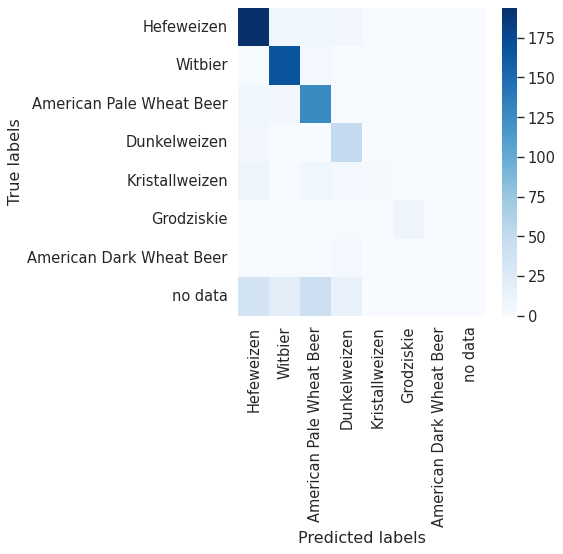

In [ ]:
for group in res:
    print('==== CLASSIFICATION REPORT FOR {} ===='.format(group))
    y_preds_ = torch.cat(res[group][0]).cpu().numpy()
    y_trues_ = torch.cat(res[group][1]).cpu().numpy()

    # Print the classification report
    print(classification_report(y_trues_, y_preds_))

    figure(figsize=(5, 5), dpi=80)
    plot_confusion_matrix(y_trues_, y_preds_, labels3[group])